In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numexpr as ne
import math
import timeit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import timeit
import functools


I0000 00:00:1700444980.357342       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/var/folders/j1/w77jn90n4xz0jc6gqk110_x00000gn/T/ipykernel_98417/1449457327.py:12: RuntimeWarning: invalid value encountered in log
  x = np.log(np.log2(abs(cheker)))


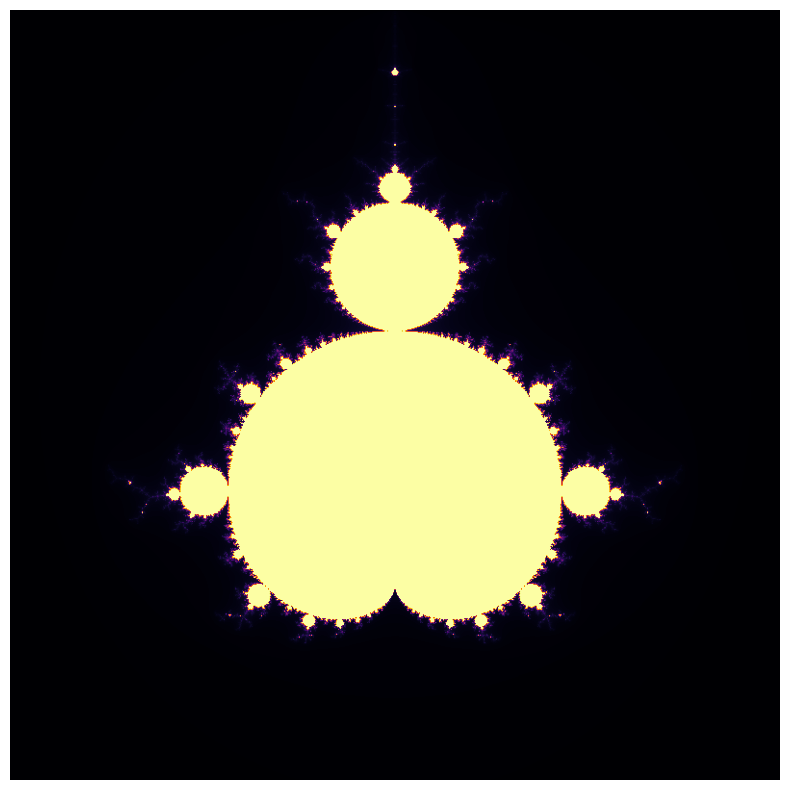

In [2]:

# function to check if number is in mondelbrot set
def mandelbrot_check_vect(c, max_iter):
    cheker = jnp.zeros(c.shape, dtype=complex)
    hit = jnp.zeros(c.shape, dtype=int)

    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')

    # grad calculation for each point
    x = np.log(np.log2(abs(cheker)))
    mask_GR = ne.evaluate('hit < max_iter')
    gradient = ne.evaluate('where(mask_GR, hit + 1 - x, hit)')
    return gradient

# drawing the Mandelbrot set
width, height = 800, 800
x = np.linspace(-2, 1, width)
y = np.linspace(-1.5, 1.5, height)
c = x[:, None] + 1j*y[None, :]

mandelbrot_image = mandelbrot_check_vect(c, 300)

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_image, cmap='inferno')
plt.axis('off')
plt.show()


In [3]:
# Here I create samples and check whether they are in mandelbrot set. I use jnp and numexpr for multithreading, 
# numpy for vectorisation and joblib for multiprocessing. Overall 11.5 times faster then area_mandel
def area_mandel_vect_numexpr(n_sampl, max_iter):
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    c = ne.evaluate("x + 1j * y")
    cheker = jnp.zeros(c.shape, dtype=complex)
    hit = jnp.zeros(c.shape, dtype=int)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), n_sampl
# Here I extract results and combine them to calculate area
def result_extraction_simple_numexpr(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(area_mandel_vect_numexpr)(samples_per_core, max_iter) for core in range(num_cores)
    )
    hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    samples = jnp.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area

In [58]:
area_estimate = result_extraction_simple_numexpr(10**6, 1000, 1)
print("Estimated area:", area_estimate)

Estimated area: 1.51623


In [130]:
max_iter = 300
num_cores = 10
total_samples = int(((10**6)/2))
res_latin_hypercube = [result_extraction_simple_numexpr(total_samples, max_iter, num_cores) for _ in range(100)]
std_latin_hypercube= np.std(res_latin_hypercube)
mean_latin_hypercube = np.mean(res_latin_hypercube)
print(f"Mean is {mean_latin_hypercube}, Sdt is {std_latin_hypercube}")

I0000 00:00:1700249291.284372       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.291552       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.296731       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.308003       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.317025       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.318208       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.322511       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.326175       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.327416       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700249291.360672       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Mean is 1.519798755645752, Sdt is 0.004402884282171726


In [4]:
# Here I create samples and check whether they are in mandelbrot set. I use jnp and numexpr for multithreading, 
# numpy for vectorisation and joblib for multiprocessing. Overall 11.5 times faster then area_mandel
def area_mandel_vect_numexp_antithetic(n_sampl, max_iter):
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    x = np.random.uniform(0, 1, n_sampl)
    y = np.random.uniform(0, 1, n_sampl)
    f_antithetic = lambda x: 1-x
    x = np.append(x,list(map(f_antithetic,x)))
    y = np.append(y,list(map(f_antithetic,y)))
    x = x_min + x*(x_max-x_min)
    y = y_min + y*(y_max-y_min)
    c = ne.evaluate("x + 1j * y")
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=int)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    #print(mask)
    return np.sum(mask), len(mask)
# Here I extract results and combine them to calculate area
def result_extraction_simple_numexpr_antithetic(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(area_mandel_vect_numexp_antithetic)(samples_per_core, max_iter) for core in range(num_cores)
    )
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / (samples))
    return area

In [5]:
# TODO: Change logic of list creation to optimise and use jnp
def stratified_sampling(n_sampl, max_iter, num ):
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    c = x_samples + 1j * y_samples
    #print(c[0])
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask == True), n_sampl

def result_extraction_stratifies(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(stratified_sampling)(samples_per_core, max_iter, 8) for core in range(num_cores)
    )
    #print(results)
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return area

In [6]:
# TODO: Change logic of list creation to optimise and use jnp
def stratified_sampling_anti(n_sampl, max_iter, num ):
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    np.random.shuffle(y_samples)
    np.random.shuffle(x_samples)
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    x_point_anti , y_points_anti = anthithetic_variable_str(x_samples, y_samples)
    #print(min(y_points_anti))
    #np.random.shuffle(x_point_anti)
    #np.random.shuffle(y_points_anti)
    x_samples = np.append(x_samples, x_point_anti)
    y_samples = np.append(y_samples, y_points_anti)
    c = x_samples + 1j * y_samples
    #print(c[0])
    cheker = np.zeros(c.shape, dtype=complex)
    hit = np.zeros(c.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + c, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask == True), n_sampl

def anthithetic_variable_str(x_point, y_point):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    #print(max(antith_y))
    return antith_x, antith_y

def result_extraction_stratifies_anti_l(total_samples, max_iter, num_cores):
    samples_per_core = total_samples // num_cores
    results = Parallel(n_jobs=num_cores)(
        delayed(stratified_sampling_anti)(samples_per_core, max_iter, 8) for core in range(num_cores)
    )
    #print(results)
    hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=float))
    #print(hits)
    samples = np.sum(np.fromiter((sampler for _, sampler in results), dtype=float))
    #print(samples)
    x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
    area = (x_max - x_min) * (y_max - y_min) * (hits / (samples*2))
    return area

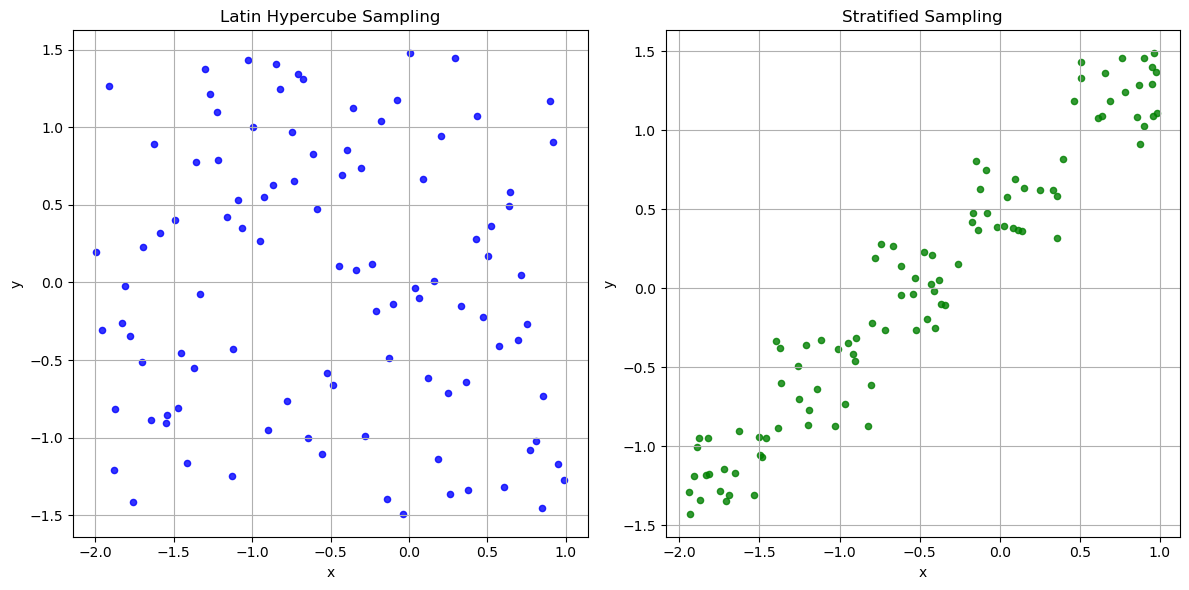

In [7]:

def latin_hypercube_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / n_sampl
    y_h = y_len / n_sampl
    x_array = np.array([x_min + x_h * a for a in range(n_sampl + 1)])
    y_array = np.array([y_min + y_h * a for a in range(n_sampl + 1)])
    x = np.array([np.random.uniform(x_array[a], x_array[a + 1], 1) for a in range(n_sampl)])
    y = np.array([np.random.uniform(y_array[a], y_array[a + 1], 1) for a in range(n_sampl)])
    #np.random.shuffle(y)
    
    return x, y
def random_sampling(n_sampl):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def area_mandel_vect_1(n_sampl):
    x_min, x_max, y_min, y_max = -2, -1.5, 0, 0.2
    x = np.random.uniform(x_min, x_max, n_sampl)
    y = np.random.uniform(y_min, y_max, n_sampl)
    return x, y
def stratified_sampling(n_sampl, num):
    x_min, x_max, y_min, y_max = -2, 1, -1.5, 1.5
    x_len = x_max - x_min
    y_len = y_max - y_min
    x_h = x_len / num
    y_h = y_len / num
    x_array = np.array([x_min + x_h * a for a in range(num + 1)])
    y_array = np.array([y_min + y_h * a for a in range(num + 1)])
    x_samples = []
    y_samples = []
    for a in range(num):
        x_samples.extend(np.random.uniform(x_array[a], x_array[a + 1], n_sampl // num))
        y_samples.extend(np.random.uniform(y_array[a], y_array[a + 1], n_sampl // num))
    #np.random.shuffle(y_samples)
    return np.array(x_samples), np.array(y_samples)


def orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    sample_per_cess = round(n_sampl/num_cells)
    n_points_in_cell = round(n_sampl/(num_cells))
    #print(f"Number of cells: {num_cells}")
    #print(f"Points per cell: {n_points_in_cell}")
    x_intervals = np.linspace(xmin, xmax, int(np.sqrt(num_cells)) + 1)
    y_intervals = np.linspace(ymin, ymax, int(np.sqrt(num_cells)) + 1)

    def generate_samples_for_cell(x_bounds, y_bounds, num_samples):
        x_strata = np.linspace(x_bounds[0], x_bounds[1], num_samples + 1)
        y_strata = np.linspace(y_bounds[0], y_bounds[1], num_samples + 1)
        cell_points = []
        for i in range(num_samples):
            x_point = np.random.uniform(x_strata[i], x_strata[i+1])
            y_point = np.random.uniform(y_strata[i], y_strata[i+1])
            cell_points.append((x_point, y_point))
        return cell_points
    all_points = []

    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            cell_points = generate_samples_for_cell(x_bounds, y_bounds, n_points_in_cell)
            x = [point[0] for point in cell_points]
            y = [point[1] for point in cell_points]
            #np.random.shuffle(y)
            #np.random.shuffle(x)
            reshuffled_points = list(map(lambda a, b: (a, b), x, y))
            all_points.extend(reshuffled_points)
    #print(f"Total points generated: {len(all_points)}")
    return np.array(all_points)
def orthogonal_sampling_full_devide(n_sampl, minmax_x, minmax_y):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    num_cells = int(np.sqrt(n_sampl))
    x_intervals = np.linspace(xmin, xmax, num_cells + 1)
    y_intervals = np.linspace(ymin, ymax, num_cells + 1)
    all_points = np.empty((n_sampl, 2))
    idx = 0
    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            x_point = np.random.uniform(x_bounds[0], x_bounds[1])
            y_point = np.random.uniform(y_bounds[0], y_bounds[1])
            all_points[idx, 0] = x_point
            all_points[idx, 1] = y_point
            idx += 1
    #np.random.shuffle(all_points[:, 0])
    #np.random.shuffle(all_points[:, 1])
    return all_points
n_sampl = 100

x_lhs, y_lhs = latin_hypercube_sampling(n_sampl)
array1 = np.array([-2, -1.7, -1.4, -1.1, -0.8, -0.5, -0.2, 0.1, 0.4, 0.7, 1])
array2 = np.array([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5])

pairs = np.array(np.meshgrid(array1, array2)).T.reshape(-1, 2) 
xf = pairs[0:,0]
yf = pairs[0,0:]
x_random, y_random = random_sampling(n_sampl)
x_rand, y_rand = area_mandel_vect_1(n_sampl)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(x_lhs, y_lhs, alpha=0.8, s=20, color='blue')  
plt.title('Latin Hypercube Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
"""
plt.subplot(1, 3, 2)
plt.scatter(x_random, y_random, alpha=0.8, s=20, color='red')  
plt.title('Random Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
"""
num =5

x_stratified, y_stratified = stratified_sampling(n_sampl, num)

plt.subplot(2, 2, 2)
plt.scatter(x_stratified, y_stratified, alpha=0.8, s=20, color='green')
plt.title('Stratified Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
minmax_x = (-2, 1)
minmax_y = (-1.5, 1.5)

num_cells = 4
points = orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells)
x_intervals = np.linspace(-2, 1, num_cells + 1)
y_intervals = np.linspace(-1.5, 1.5, num_cells + 1)
plt.subplot(2, 2, 3)
plt.scatter(points[:, 0], points[:, 1], color='purple', marker='o')
for x in x_intervals:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_intervals:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
plt.title('Orthogonal Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.tight_layout()
num_cells = 10
points = orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells)
x_intervals = np.linspace(-2, 1, num_cells + 1)
y_intervals = np.linspace(-1.5, 1.5, num_cells + 1)
points = orthogonal_sampling_full_devide(n_sampl, minmax_x, minmax_y)
plt.subplot(2, 2, 4)
plt.scatter(points[:, 0], points[:, 1], color='brown', marker='o')
for x in x_intervals:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_intervals:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
plt.title('Orthogonal Sampling Full')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.tight_layout()
plt.show()


In [7]:
def generate_samples(n_sampl, minmax):
    #print(n_sampl)
    xmin , xmax = minmax
    intervals = np.linspace(xmin, xmax, n_sampl+1)
    #print(intervals)
    f = lambda pair: np.random.uniform(pair[0], pair[1])
    mapflt = lambda f, xs: map(f, zip(xs, xs[1:]))
    points = list(mapflt(f, intervals))
    #print(points)
    return points
# TODO: maybe spreading x, y between two chunks of processors is faster??
def latin_hypercube_parallel(total_samples, dimensions, num_cores):
    samples_per_core = (total_samples) // (num_cores)
    x_strata_per_core = np.linspace(-2, 0.5, (num_cores+1))
    y_strata_per_core = np.linspace(-1.5, 1.5, (num_cores+1))
    #print(x_strata_per_core)
    f = lambda x , y : (x[y], x[y+1])
    results_x = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(x_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_x)
    results_y = Parallel(n_jobs=num_cores)(
        delayed(generate_samples)(samples_per_core, f(y_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_y)
    combo_x = np.concatenate(results_x)
    #print(combined_samples_x)
    combo_y = np.concatenate(results_y)
    combo =  np.vstack((combo_x, combo_y))
    #print("combo: ", combo)
    return combo.T

def latin_hypercube_mandelbrot_check(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples
def latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores):
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(latin_hypercube_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    #np.random.shuffle(x_points)
    np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = latin_hypercube_parallel(total_samples, 2, num_cores)
    #print(points)
    c = transform_points_to_complex(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = latin_hypercube_parallel_mandelbrot(c, max_iter, num_cores)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 1000
num_cores = 8
total_samples = 10**6
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)
print(f"Estimated area of the Mandelbrot set: {area}")


I0000 00:00:1700444999.098066       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.110116       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.113809       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.120330       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.133831       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.156119       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.175968       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700444999.189343       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Estimated area of the Mandelbrot set: 1.5118350982666016


In [8]:
def generate_samples_lhc_anti(n_sampl, minmax):
    #print(n_sampl)
    xmin , xmax = minmax
    intervals = np.linspace(xmin, xmax, n_sampl+1)
    #print(intervals)
    f = lambda pair: np.random.uniform(pair[0], pair[1])
    mapflt = lambda f, xs: map(f, zip(xs, xs[1:]))
    points = list(mapflt(f, intervals))
    #print(points)
    return points

# TODO: maybe spreading x, y between two chunks of processors is faster??
def latin_hypercube_parallel(total_samples, dimensions, num_cores):
    samples_per_core = round(total_samples / num_cores)
    x_strata_per_core = np.linspace(-2, 0.5, (num_cores+1))
    y_strata_per_core = np.linspace(-1.5, 1.5, (num_cores+1))
    #print(x_strata_per_core)
    f = lambda x , y : (x[y], x[y+1])
    results_x = Parallel(n_jobs=num_cores)(
        delayed(generate_samples_lhc_anti)(samples_per_core, f(x_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_x)
    results_y = Parallel(n_jobs=num_cores)(
        delayed(generate_samples_lhc_anti)(samples_per_core, f(y_strata_per_core, core)) for core in range(num_cores)
    )
    #print(results_y)
    combo_x = np.concatenate(results_x)
    #print(combined_samples_x)
    combo_y = np.concatenate(results_y)
    combo =  np.vstack((combo_x, combo_y))
    #print("combo: ", combo)
    return combo.T

def anthithetic_variable_lhc(x_point, y_point):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    #print(max(antith_y))
    return antith_x, antith_y

def latin_hypercube_mandelbrot_check_anti(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples but ? might fuckup if number of cores is odd ?
def latin_hypercube_parallel_mandelbrot_anti(c, max_iter, num_cores):
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(latin_hypercube_mandelbrot_check_anti)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex_lhc(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    #np.random.shuffle(x_points)
    x_point_anti , y_points_anti = anthithetic_variable_lhc(x_points, y_points)
    #print(min(y_points_anti))
    #np.random.shuffle(x_point_anti)
    #np.random.shuffle(y_points_anti)
    x_points = np.append(x_points, x_point_anti)
    y_points = np.append(y_points, y_points_anti)
    return  ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_antithetic_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = latin_hypercube_parallel(total_samples, 2, num_cores)
    #print(points)
    c = transform_points_to_complex_lhc(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samp = latin_hypercube_parallel_mandelbrot_anti(c, max_iter, num_cores)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / (total_samples*2))
    return mandelbrot_area

max_iter = 1000
num_cores = 10
total_samples = (10**3)
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot_antithetic_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)
print(f"Estimated area of the Mandelbrot set: {area}")


Estimated area of the Mandelbrot set: 1.4437499046325684


Origonal:  [[-0.37667191 -1.47048158]
 [-0.65275807 -0.35879129]
 [-0.318357    0.67674791]
 [-0.4434052  -1.13820082]
 [-1.26297907 -0.66072879]
 [-1.81505268  1.02052958]
 [ 0.2367923  -0.41700838]
 [-0.20085177 -1.32517693]
 [-1.35658543 -1.26469878]
 [-1.08271049 -1.03559287]
 [ 0.3956106  -0.34577917]
 [-0.00397233  1.19107814]
 [-0.26921892 -0.44836767]
 [-0.26664485  0.17510051]
 [-0.11911636 -1.4299255 ]
 [-0.76609337  1.078618  ]
 [-0.15306138 -0.95660847]
 [-1.38328054  0.66028653]
 [-0.32776598 -1.41769155]
 [-0.99474525 -0.94595905]
 [-1.56993055  0.94856553]
 [-1.47040434 -0.49023182]
 [ 0.16248678  1.49147999]
 [-0.79753064  1.14084649]
 [-0.57505718 -0.90521365]
 [-0.56189794  1.17143741]
 [-1.15783008  0.0076163 ]
 [ 0.03073421 -0.18696401]
 [-1.15156082  0.54711741]
 [-1.47980221 -1.05715955]
 [-1.96300841 -1.44079533]
 [-0.55186381 -1.41864737]
 [-1.21366508 -1.38015309]
 [-0.09350922  0.63323301]
 [-0.8230668   0.65917655]
 [-1.110427   -0.07348925]
 [ 0.15710267 -1.

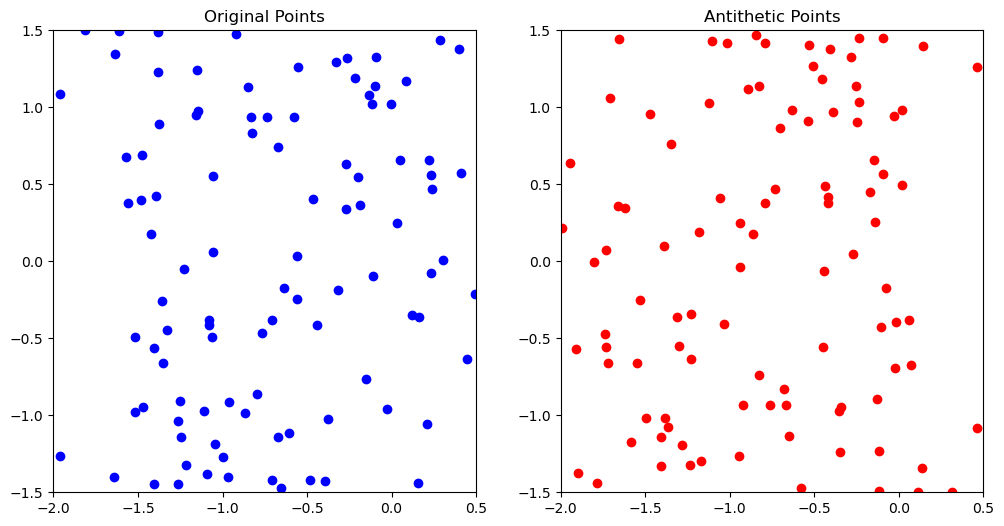

In [10]:

def anthithetic_variable(x_point, y_point ):
    bound_x = (-2, 0.5)
    bound_y = (-1.5, 1.5) 
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    print("x point: ", x_point)
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    print(antith_x)
    #print(antith_y)
    return antith_x, antith_y

def transform_points_to_complex(points):
    x_points = points[:, 0]
    y_points = points[:, 1]
    np.random.shuffle(y_points)
    np.random.shuffle(x_points)
    
    x_point_anti, y_points_anti = anthithetic_variable(x_points, y_points)
    """
    x_points = np.append(x_points, x_point_anti)
    y_points = np.append(y_points, y_points_anti)
    np.random.shuffle(y_points)
    np.random.shuffle(x_points)
    """
    return np.column_stack((x_point_anti, y_points_anti))

num_points = 100
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
original_points = np.random.uniform(low=(x_min, y_min), high=(x_max, y_max), size=(num_points, 2))
print("Origonal: ", original_points)
transformed_points = transform_points_to_complex(original_points)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_points[:, 0], original_points[:, 1], color='blue')
plt.title("Original Points")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.subplot(1, 2, 2)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
plt.title("Antithetic Points")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.show()


In [9]:
def orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    sample_per_cess = round(n_sampl/num_cells)
    n_points_in_cell = round(n_sampl/(num_cells))
    #print(f"Number of cells: {num_cells}")
    #print(f"Points per cell: {n_points_in_cell}")
    x_intervals = np.linspace(xmin, xmax, int(np.sqrt(num_cells)) + 1)
    y_intervals = np.linspace(ymin, ymax, int(np.sqrt(num_cells)) + 1)

    # Function to generate samples for a given cell
    def generate_samples_for_cell(x_bounds, y_bounds, num_samples):
        x_strata = np.linspace(x_bounds[0], x_bounds[1], num_samples + 1)
        y_strata = np.linspace(y_bounds[0], y_bounds[1], num_samples + 1)
        cell_points = []
        for i in range(num_samples):
            x_point = np.random.uniform(x_strata[i], x_strata[i+1])
            y_point = np.random.uniform(y_strata[i], y_strata[i+1])
            cell_points.append((x_point, y_point))
        return cell_points
    all_points = []

    # Generate and reshuffle points for each cell
    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            cell_points = generate_samples_for_cell(x_bounds, y_bounds, n_points_in_cell)
            x = [point[0] for point in cell_points]
            y = [point[1] for point in cell_points]
            np.random.shuffle(y)
            #np.random.shuffle(x)
            reshuffled_points = list(map(lambda a, b: (a, b), x, y))
            all_points.extend(reshuffled_points)
    #print(f"Total points generated: {len(all_points)}")
    return np.array(all_points)

def orth_mandelbrot_check(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples
def ortog_parallel_mandelbrot(c, max_iter, num_cores):
    #print(len(c))
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(orth_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex_orth(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    #np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_orthogonal(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max, n_cells):
    points = orthogonal_sampling(total_samples, (x_min, x_max), (y_min, y_max),n_cells )
    #print(len(points))
    #print(points)
    c = transform_points_to_complex_orth(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = ortog_parallel_mandelbrot(c, max_iter, num_cores)
    #print("samples ",samples)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 1000
num_cores = 10
total_samples = 10**6
n_cells = 4
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot_orthogonal(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max,n_cells)
print(f"Estimated area of the Mandelbrot set: {area}")


I0000 00:00:1700445017.049000       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1700445017.076034       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Estimated area of the Mandelbrot set: 1.5089625120162964


In [10]:
def orthogonal_sampling_full_devide(n_sampl, minmax_x, minmax_y):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    num_cells = int(np.sqrt(n_sampl))
    x_intervals = np.linspace(xmin, xmax, num_cells + 1)
    y_intervals = np.linspace(ymin, ymax, num_cells + 1)
    all_points = np.empty((n_sampl, 2))
    idx = 0
    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            x_point = np.random.uniform(x_bounds[0], x_bounds[1])
            y_point = np.random.uniform(y_bounds[0], y_bounds[1])
            all_points[idx, 0] = x_point
            all_points[idx, 1] = y_point
            idx += 1
    #np.random.shuffle(all_points[:, 0])
    #np.random.shuffle(all_points[:, 1])
    return all_points

def ortog_full_mandelbrot_check(chunk, max_iter):
    cheker = np.zeros(chunk.shape, dtype=complex)
    hit = np.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = np.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return np.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples
def ortog_full_parallel_mandelbrot(c, max_iter, num_cores):
    chunks = np.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(ortog_full_mandelbrot_check)(chunk, max_iter) for chunk in chunks
    )
    total_hits = np.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = np.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex_ortog_full(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    #np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_full(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max):
    points = orthogonal_sampling_full_devide(total_samples, (x_min, x_max), (y_min, y_max))
    #print(len(points))
    #print(points)
    c = transform_points_to_complex_ortog_full(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = ortog_full_parallel_mandelbrot(c, max_iter, num_cores)
    print("samples ",samples)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 500
num_cores = 10
total_samples = 10**6
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5


In [102]:
r = calculate_area_of_mandelbrot_full(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)

samples  1000000


In [91]:
r

1.5140925

In [ ]:
r = np.array([[calculate_area_of_mandelbrot_full(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)] for max_iter in range(250, 500, 50)])


In [11]:
def orthogonal_sampling_ani(n_sampl, minmax_x, minmax_y, num_cells):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    sample_per_cess = round(n_sampl/num_cells)
    n_points_in_cell = round(n_sampl/(num_cells))
    #print(f"Number of cells: {num_cells}")
    #print(f"Points per cell: {n_points_in_cell}")
    x_intervals = np.linspace(xmin, xmax, int(np.sqrt(num_cells)) + 1)
    y_intervals = np.linspace(ymin, ymax, int(np.sqrt(num_cells)) + 1)

    # Function to generate samples for a given cell
    def generate_samples_for_cell(x_bounds, y_bounds, num_samples):
        x_strata = np.linspace(x_bounds[0], x_bounds[1], num_samples + 1)
        y_strata = np.linspace(y_bounds[0], y_bounds[1], num_samples + 1)
        cell_points = []
        for i in range(num_samples):
            x_point = np.random.uniform(x_strata[i], x_strata[i+1])
            y_point = np.random.uniform(y_strata[i], y_strata[i+1])
            cell_points.append((x_point, y_point))
        return cell_points
    all_points = []

    # Generate and reshuffle points for each cell
    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            cell_points = generate_samples_for_cell(x_bounds, y_bounds, n_points_in_cell)
            x = [point[0] for point in cell_points]
            y = [point[1] for point in cell_points]
            np.random.shuffle(y)
            x_point_anti , y_points_anti = anthithetic_variable_ortog(x, y, x_bounds,  y_bounds)
            #print(min(y_points_anti))
            #np.random.shuffle(x_point_anti)
            #np.random.shuffle(y_points_anti)
            x = np.append(x, x_point_anti)
            y = np.append(y, y_points_anti)
            reshuffled_points = list(map(lambda a, b: (a, b), x, y))
            all_points.extend(reshuffled_points)
    #print(f"Total points generated: {len(all_points)}")
    return np.array(all_points)

def anthithetic_variable_ortog(x_point, y_point, x_bounds, y_bounds ):
    bound_x = x_bounds
    bound_y = y_bounds
    length_x = bound_x[1] - bound_x[0]
    length_y = bound_y[1] - bound_y[0]
    f_mirror = lambda bound, length, x : bound[1] - (x - bound[0])
    f_antithtic_x = lambda array: list(map(lambda x: f_mirror(bound_x, length_x, x), array))
    f_antithtic_y = lambda array: list(map(lambda x: f_mirror(bound_y, length_y, x), array))
    antith_x = f_antithtic_x(x_point)
    antith_y = f_antithtic_y(y_point)
    #print(max(antith_y))
    return antith_x, antith_y

def mandelbrot_check_ortog_anti(chunk, max_iter):
    cheker = jnp.zeros(chunk.shape, dtype=complex)
    hit = jnp.zeros(chunk.shape, dtype=float)
    for _ in range(max_iter):
        mask = jnp.abs(cheker) <= 2
        cheker = ne.evaluate('where(mask, cheker**2 + chunk, cheker)')
        hit = ne.evaluate('where(mask, hit + 1, hit)')
    return jnp.sum(mask), len(chunk)

# TODO: really no need to save or pass totall samples
def ortog_anti_parallel_mandelbrot(c, max_iter, num_cores):
    #print(len(c))
    chunks = jnp.array_split(c, num_cores)
    results = Parallel(n_jobs=num_cores)(
        delayed(mandelbrot_check_ortog_anti)(chunk, max_iter) for chunk in chunks
    )
    total_hits = jnp.sum(np.fromiter((hit for hit, _ in results), dtype=int))
    total_samples = jnp.sum(np.fromiter((sampl for _, sampl in results), dtype=int))

    return total_hits, total_samples

# TODO: could perhaps be merged with sample genrator since I dont scale it anymore
def transform_points_to_complex_ortog_anti(points, x_min, x_max, y_min, y_max):
    #print(len(points))
    x_points = points[:, 0]
    y_points = points[:, 1]
    #np.random.shuffle(y_points)
    return ne.evaluate('x_points + 1j * y_points')


def calculate_area_of_mandelbrot_orthogonal_anti(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max, n_cells):
    points = orthogonal_sampling_ani(total_samples, (x_min, x_max), (y_min, y_max),n_cells )
    #print(len(points))
    #print(points)
    c = transform_points_to_complex_ortog_anti(points, x_min, x_max, y_min, y_max)
    #print("c: ", c)
    hits, samples = ortog_anti_parallel_mandelbrot(c, max_iter, num_cores)
    #print("samples ",samples)
    #print(samples)
    mandelbrot_area = (x_max - x_min) * (y_max - y_min) * (hits / samples)
    return mandelbrot_area

max_iter = 1000
num_cores = 10
total_samples = 10**6
n_cells = 4
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5

area = calculate_area_of_mandelbrot_orthogonal_anti(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max,n_cells)
print(f"Estimated area of the Mandelbrot set: {area}")


Estimated area of the Mandelbrot set: 1.510968804359436


Number of cells: 100
Points per cell: 100
Total points generated: 10000


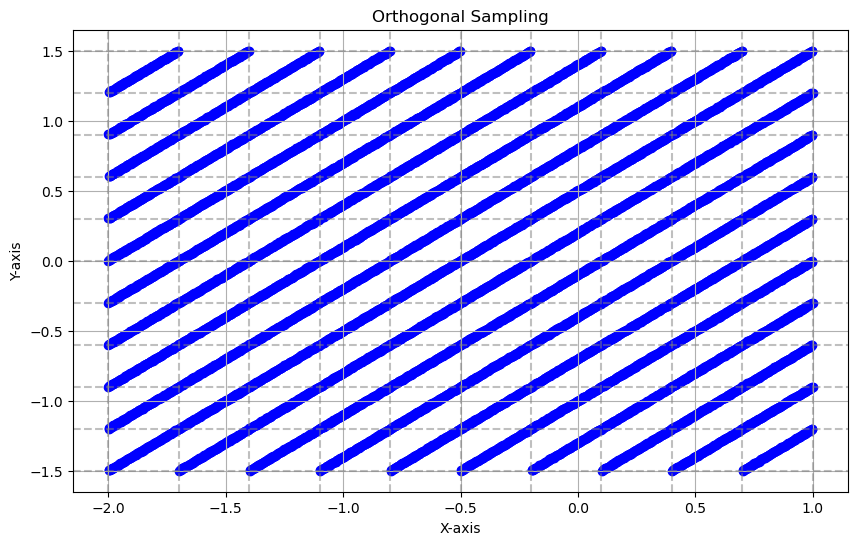

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells):
    xmin, xmax = minmax_x
    ymin, ymax = minmax_y
    sample_per_cess = round(n_sampl/num_cells)
    n_points_in_cell = round(n_sampl/(num_cells**2))
    print(f"Number of cells: {num_cells**2}")
    print(f"Points per cell: {n_points_in_cell}")
    x_intervals = np.linspace(xmin, xmax, num_cells + 1)
    y_intervals = np.linspace(ymin, ymax, num_cells + 1)

    # Function to generate samples for a given cell
    def generate_samples_for_cell(x_bounds, y_bounds, num_samples):
        x_strata = np.linspace(x_bounds[0], x_bounds[1], num_samples + 1)
        y_strata = np.linspace(y_bounds[0], y_bounds[1], num_samples + 1)
        cell_points = []
        for i in range(num_samples):
            x_point = np.random.uniform(x_strata[i], x_strata[i+1])
            y_point = np.random.uniform(y_strata[i], y_strata[i+1])
            cell_points.append((x_point, y_point))
        return cell_points
    all_points = []

    # Generate and reshuffle points for each cell
    for x_bounds in zip(x_intervals, x_intervals[1:]):
        for y_bounds in zip(y_intervals, y_intervals[1:]):
            cell_points = generate_samples_for_cell(x_bounds, y_bounds, n_points_in_cell)
            x = [point[0] for point in cell_points]
            y = [point[1] for point in cell_points]
            #np.random.shuffle(y)
            reshuffled_points = list(map(lambda a, b: (a, b), x, y))
            all_points.extend(reshuffled_points)
    print(f"Total points generated: {len(all_points)}")
    return np.array(all_points)

# Define parameters
n_sampl = 10000
minmax_x = (-2, 1)
minmax_y = (-1.5, 1.5)

# Generate points
num_cells = 10
points = orthogonal_sampling(n_sampl, minmax_x, minmax_y, num_cells)
x_intervals = np.linspace(-2, 1, num_cells + 1)
y_intervals = np.linspace(-1.5, 1.5, num_cells + 1)
# Draw the grid corresponding to the cells
plt.figure(figsize=(10, 6))
plt.scatter(points[:, 0], points[:, 1], color='blue', marker='o')
for x in x_intervals:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_intervals:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
# Plotting
plt.title("Orthogonal Sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()


In [13]:

def simulation_ineration(total_samples, num_cores, x_min, x_max, y_min, y_max, n_cell):
    results = []
    res = np.array([[calculate_area_of_mandelbrot_orthogonal(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max, n_cell) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[calculate_area_of_mandelbrot_orthogonal_anti(int(total_samples/2), max_iter, num_cores, x_min, x_max, y_min, y_max, n_cell) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[calculate_area_of_mandelbrot_full(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res= np.array([[calculate_area_of_mandelbrot_antithetic_lhc(int(total_samples/2), max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[calculate_area_of_mandelbrot_lhc(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[result_extraction_stratifies_anti_l(int(total_samples/2), max_iter, num_cores) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[result_extraction_stratifies(total_samples, max_iter, num_cores) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res= np.array([[result_extraction_simple_numexpr(total_samples, max_iter, num_cores) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    print("rfne")
    res = np.array([[result_extraction_simple_numexpr_antithetic(int(total_samples/2), max_iter, num_cores) for _ in range(100)] for max_iter in range(300, 1000, 50)])
    results.append(res)
    return results

num_cores = 10
total_samples = 10**6
n_cells = 50
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
res = simulation_ineration(total_samples, num_cores, x_min, x_max, y_min, y_max, n_cells)


In [73]:
num_cores = 10
total_samples = 10**6
max_iter = 400
x_min, x_max, y_min, y_max = -2, 0.5, -1.5, 1.5
r = calculate_area_of_mandelbrot_full(total_samples, max_iter, num_cores, x_min, x_max, y_min, y_max)

Number of cells: 1000
Points per cell: 1
samples  1000000


In [33]:
fstd = lambda array: [np.std(sub_array) for sub_array in array]
fmean = lambda array: [np.mean(sub_array) for sub_array in array]
fn = lambda array: [len(sub_array) for sub_array in array]
std_v = list(map(fstd, res))
mean_v = list(map(fmean, res))
n = list(map(fn, res))

In [56]:
x = np.linspace(250, 500, 5)
print(len(mean_v[0]))
for p in range(len(res)):
    #plt.plot(x, len(std_v[p]), label=p)
    #plt.legend()
    print(len(res[p][0]))
print(res[1][0])


5
100
100
100
100
100
100
100
100
100
[1.5210834 1.5194167 1.5166667 1.5330833 1.53225   1.5183333 1.5165833
 1.5260834 1.5200833 1.5275    1.5206667 1.5231667 1.5249166 1.5160834
 1.5151666 1.5304999 1.5234168 1.5259167 1.5217501 1.5240834 1.5149167
 1.5280833 1.5275834 1.5188334 1.5180833 1.5251666 1.523     1.51875
 1.5280833 1.5222499 1.5154167 1.5184166 1.5164167 1.5267501 1.518
 1.5285833 1.5175834 1.5221667 1.5224999 1.5125834 1.5174999 1.5165
 1.5273333 1.5190834 1.5175834 1.5224167 1.5225834 1.5218333 1.5225834
 1.5239167 1.5245833 1.51875   1.5255    1.52075   1.5178334 1.5285
 1.5131667 1.5264167 1.5256666 1.522     1.517     1.5166667 1.5140833
 1.5279167 1.5222499 1.5243334 1.5215001 1.5239167 1.5238334 1.517
 1.5273333 1.5235833 1.52325   1.5210834 1.526     1.5305834 1.5166667
 1.5191666 1.5218333 1.52375   1.5145    1.523     1.5185834 1.53075
 1.5189166 1.5286667 1.5238334 1.51925   1.5229167 1.5180833 1.5195833
 1.5213333 1.52525   1.5179167 1.51975   1.5243334 1.5201